In [1]:
import numpy as np
import pandas as pd
import arviz as az
from cmdstanpy import CmdStanModel

In [4]:
def center(vals: np.ndarray) -> np.ndarray:
    return vals - np.nanmean(vals)


def standardize(vals: np.ndarray) -> np.ndarray:
    centered_vals = center(vals)
    return centered_vals / np.nanstd(centered_vals)

In [5]:
d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';', header=0)
d['A'] = standardize(d['MedianAgeMarriage'])
d['D'] = standardize(d['Divorce'])
d['M'] = standardize(d['Marriage'])

In [66]:
divorce_code = '''
data{
    int<lower=1> N;
    int<lower=1> N_M;
    vector[N] D;
    vector[N_M] M;
    vector[N] A;
}

parameters{
    real a;
    real bM;
    real bA;
    real<lower=0> sigma;
    real aM;
    real bAM;
    real<lower=0> sigma_M;
}

model{
    vector[N_M] mu_M;
    sigma_M ~ exponential(1);
    bAM ~ normal(0, 0.5);
    aM ~ normal(0, 0.2);
    for ( i in 1:N_M ) {
        mu_M[i] = aM + bAM * A[i];
    }
    M ~ normal(mu_M, sigma_M);
    
    vector[N] mu;
    sigma ~ exponential(1);
    bA ~ normal(0, 0.5);
    bM ~ normal(0, 0.5);
    a ~ normal(0, 0.2);
    for ( i in 1:N ) {
        mu[i] = a + bM * M[i] + bA * A[i];
    }
    D ~ normal(mu, sigma);
}

generated quantities{
    vector[N_M] mu_M;
    vector[N] mu;
    for ( i in 1:N_M ) {
        mu_M[i] = aM + bAM * A[i];
    }
    for (i in 1:N) {
        mu[i] = a + bM * M[i] + bA * A[i];
    }
}

'''

In [67]:
stan_file = './stan_models/waffledivorce.stan'
with open(stan_file, 'w') as f:
    print(divorce_code, file=f)

stan_model = CmdStanModel(stan_file=stan_file)

09:36:09 - cmdstanpy - INFO - compiling stan file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/waffledivorce.stan to exe file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/waffledivorce
09:36:19 - cmdstanpy - INFO - compiled model executable: /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/waffledivorce


In [68]:
data = d[['A', 'M', 'D']].to_dict(orient='list')
data['N'] = len(data['A'])
data['N_M'] = len(data['M'])

In [69]:
fit = stan_model.sample(data=data)

09:36:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:36:24 - cmdstanpy - INFO - CmdStan done processing.
09:36:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'waffledivorce.stan', line 28, column 4 to column 30)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'waffledivorce.stan', line 28, column 4 to column 30)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'waffledivorce.stan', line 28, column 4 to column 30)
Consider re-running with show_console=True if the above output is unclear!


In [70]:
fit.summary(percentiles=(5.5, 94.5))

,Mean,MCSE,StdDev,MAD,5.5%,94.5%,ESS_bulk,ESS_tail,R_hat
lp__,-27.855900,0.043760,1.878440,1.707360,-31.358100,-25.482600,1836.33,2653.55,1.000540
a,0.002269,0.001257,0.099648,0.099940,-0.154320,0.160894,6372.16,3169.40,0.999931
bM,-0.059924,0.002761,0.156174,0.150423,-0.307442,0.189333,3176.31,3272.38,1.000260
bA,-0.608451,0.002813,0.158746,0.155661,-0.863352,-0.361360,3227.76,2772.65,0.999858
sigma,0.834684,0.001271,0.086350,0.083928,0.708605,0.980891,4848.21,2876.90,0.999598
...,...,...,...,...,...,...,...,...,...
mu[46],-0.174883,0.001564,0.112707,0.113186,-0.355079,0.001434,5229.66,3327.54,1.000670
mu[47],0.057883,0.001447,0.107040,0.107582,-0.112033,0.225593,5530.99,3292.86,0.999988
mu[48],0.489931,0.002031,0.142749,0.143248,0.261040,0.718076,5037.38,3391.31,1.000810
mu[49],-0.072865,0.002095,0.145710,0.144793,-0.308280,0.154835,4877.33,3341.85,1.000740


In [71]:
fit.draws().shape

(1000, 4, 114)

/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<Axes: >

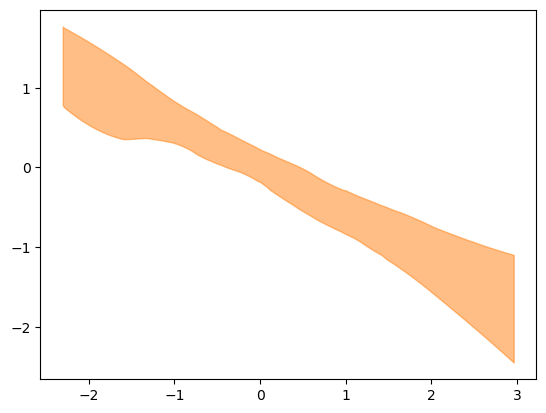

In [73]:
# Extract mu samples
mu_samples = fit.draws_pd(vars="mu")  # Extract all draws of 'mu'

# Convert to numpy array for HDI calculation
mu_array = mu_samples.to_numpy()  # Shape: (N, num_samples)

az.plot_hdi(d.A, mu_array, hdi_prob=0.89)

<Axes: >

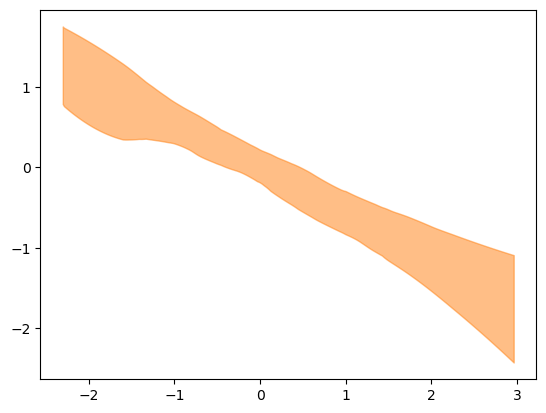

In [44]:
cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    constant_data={'A': d.A},
    observed_data={"D": d.D},
)
az.plot_hdi(d.A , cmdstanpy_data.posterior.mu, hdi_prob=0.89)

In [52]:
new_data = {'A': np.linspace(-2,2,30), 'N': 30, 'N_M': 30, 'M': np.zeros(30), 'D':np.zeros(30)}
new_quant = stan_model.generate_quantities(data=new_data, previous_fit=fit)

21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [2] start processing
21:25:43 - cmdstanpy - INFO - Chain [3] start processing
21:25:43 - cmdstanpy - INFO - Chain [4] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [3] done processing
21:25:43 - cmdstanpy - INFO - Chain [2] done processing
21:25:43 - cmdstanpy - INFO - Chain [4] done processing
